In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import onnxruntime as ort
import time

print(ort.__version__)

1.23.0


In [2]:
input_filename = "sample.jpg"
output_filename = "sample_upscaled.jpg"
model_name ='realesr-general-x4v3'

half = True
if half:
    model_filename = model_name + '-fp16' + '.onnx'
else:
    model_filename = model_name + '.onnx'

In [3]:
img = cv2.imread(input_filename)
input_imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
input_imgRGB_normalized = input_imgRGB / 255.0
input_blob = input_imgRGB_normalized.transpose(2, 0, 1)
input_blob = input_blob[np.newaxis, ...].astype(np.float32)
if half:
    input_blob = input_blob.astype(np.float16)
print(input_blob.shape)

(1, 3, 452, 640)


In [4]:
provider = 'DmlExecutionProvider'
if not provider in ort.get_available_providers():
    print(f"provider {provider} not found in {ort.get_available_providers()}")
else:
    sess = ort.InferenceSession(model_filename, providers=[provider], provider_options=[{'device_id': 1}])
    input_name = sess.get_inputs()[0].name
    output_name = sess.get_outputs()[0].name

    for i in range(10):
        start_time = time.time()
        output = sess.run([output_name], {input_name: input_blob})[0]
        end_time = time.time()
        print("onnx inference time: ", end_time - start_time)

onnx inference time:  0.34564948081970215
onnx inference time:  0.20868468284606934
onnx inference time:  0.20633411407470703
onnx inference time:  0.20639777183532715
onnx inference time:  0.20527362823486328
onnx inference time:  0.20849347114562988
onnx inference time:  0.20861196517944336
onnx inference time:  0.20737004280090332
onnx inference time:  0.20836091041564941
onnx inference time:  0.2061171531677246


In [5]:
provider = 'CUDAExecutionProvider'
if not provider in ort.get_available_providers():
    print(f"provider {provider} not found in {ort.get_available_providers()}")
else:
    sess = ort.InferenceSession(model_filename, providers=[provider])
    input_name = sess.get_inputs()[0].name
    output_name = sess.get_outputs()[0].name

    for i in range(10):
        start_time = time.time()
        output = sess.run([output_name], {input_name: input_blob})[0]
        end_time = time.time()
        print("onnx inference time: ", end_time - start_time)   

provider CUDAExecutionProvider not found in ['DmlExecutionProvider', 'CPUExecutionProvider']


In [6]:
print(type(output))
print(output.shape)
output_img = output.squeeze().transpose(1, 2, 0)
output_imgRGB = (output_img * 255).round().clip(0, 255).astype(np.uint8)

output_imgBGR = cv2.cvtColor(output_imgRGB, cv2.COLOR_RGB2BGR)
cv2.imwrite(output_filename, output_imgBGR)

<class 'numpy.ndarray'>
(1, 3, 1808, 2560)


True

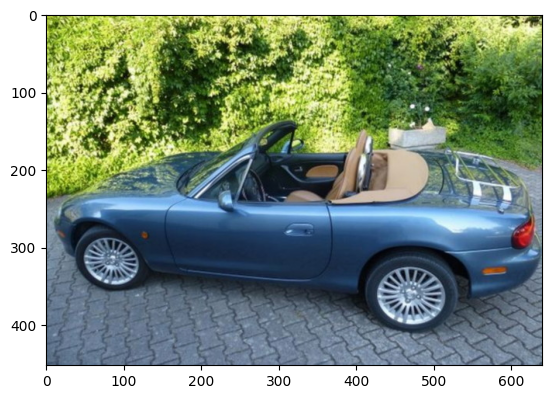

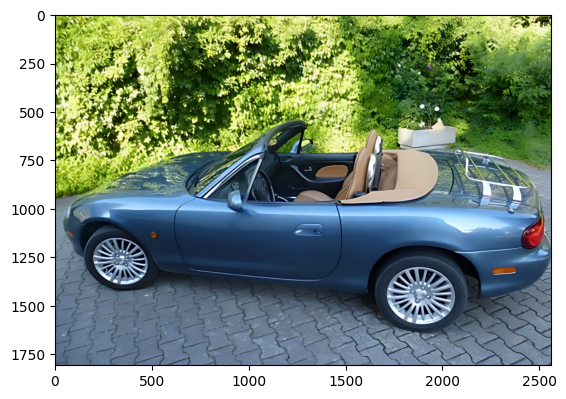

In [7]:
plt.imshow(input_imgRGB)
plt.figure()
plt.imshow(output_imgRGB)

In [8]:
import torch
from torch import nn as nn
from torch.nn import functional as F

class SRVGGNetCompact(nn.Module):
    """A compact VGG-style network structure for super-resolution.

    It is a compact network structure, which performs upsampling in the last layer and no convolution is
    conducted on the HR feature space.

    Args:
        num_in_ch (int): Channel number of inputs. Default: 3.
        num_out_ch (int): Channel number of outputs. Default: 3.
        num_feat (int): Channel number of intermediate features. Default: 64.
        num_conv (int): Number of convolution layers in the body network. Default: 16.
        upscale (int): Upsampling factor. Default: 4.
        act_type (str): Activation type, options: 'relu', 'prelu', 'leakyrelu'. Default: prelu.
    """

    def __init__(self, num_in_ch=3, num_out_ch=3, num_feat=64, num_conv=16, upscale=4, act_type='prelu'):
        super(SRVGGNetCompact, self).__init__()
        self.num_in_ch = num_in_ch
        self.num_out_ch = num_out_ch
        self.num_feat = num_feat
        self.num_conv = num_conv
        self.upscale = upscale
        self.act_type = act_type

        self.body = nn.ModuleList()
        # the first conv
        self.body.append(nn.Conv2d(num_in_ch, num_feat, 3, 1, 1))
        # the first activation
        if act_type == 'relu':
            activation = nn.ReLU(inplace=True)
        elif act_type == 'prelu':
            activation = nn.PReLU(num_parameters=num_feat)
        elif act_type == 'leakyrelu':
            activation = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        self.body.append(activation)

        # the body structure
        for _ in range(num_conv):
            self.body.append(nn.Conv2d(num_feat, num_feat, 3, 1, 1))
            # activation
            if act_type == 'relu':
                activation = nn.ReLU(inplace=True)
            elif act_type == 'prelu':
                activation = nn.PReLU(num_parameters=num_feat)
            elif act_type == 'leakyrelu':
                activation = nn.LeakyReLU(negative_slope=0.1, inplace=True)
            self.body.append(activation)

        # the last conv
        self.body.append(nn.Conv2d(num_feat, num_out_ch * upscale * upscale, 3, 1, 1))
        # upsample
        self.upsampler = nn.PixelShuffle(upscale)

    def forward(self, x):
        out = x
        for i in range(0, len(self.body)):
            out = self.body[i](out)

        out = self.upsampler(out)
        # add the nearest upsampled image, so that the network learns the residual
        base = F.interpolate(x, scale_factor=self.upscale, mode='nearest')
        out += base
        return out


In [9]:
model_path = 'realesr-general-x4v3.pth'

model = SRVGGNetCompact(num_in_ch=3, num_out_ch=3, num_feat=64, num_conv=32, upscale=4, act_type='prelu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loadnet = torch.load(model_path, map_location=torch.device('cpu'))
if 'params_ema' in loadnet:
    keyname = 'params_ema'
else:
    keyname = 'params'
model.load_state_dict(loadnet[keyname], strict=True)
model.eval()

if half:
    model = model.half()

model = model.to(device)

In [10]:
input_blob_torch = torch.from_numpy(input_blob).float()

if half:
    input_blob_torch = input_blob_torch.half()

for i in range(10):
    with torch.no_grad():
        start_time = time.time()
        input_blob_torch_device = input_blob_torch.to(device)
        output_blob_torch = model(input_blob_torch_device)
        output_blob_torch_cpu = output_blob_torch.cpu()
        end_time = time.time()
        print("torch inference time: ", end_time - start_time)

torch inference time:  0.2723667621612549
torch inference time:  0.11393976211547852
torch inference time:  0.10656332969665527
torch inference time:  0.10873174667358398
torch inference time:  0.10685276985168457
torch inference time:  0.10747599601745605
torch inference time:  0.10642027854919434
torch inference time:  0.10682821273803711
torch inference time:  0.10762643814086914
torch inference time:  0.10892438888549805


In [11]:
output_img_torch = output_blob_torch_cpu.numpy().squeeze().transpose(1, 2, 0)
output_imgRGB_torch = (output_img_torch * 255).round().clip(0, 255).astype(np.uint8)

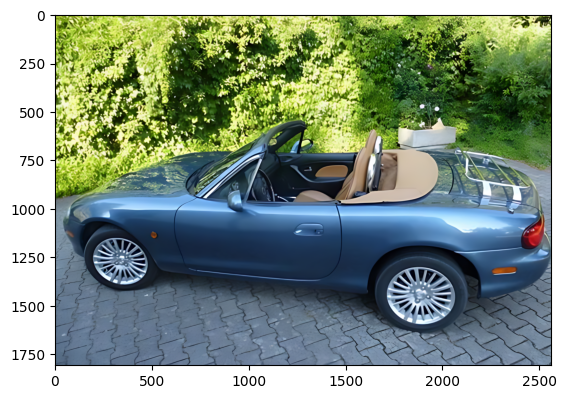

In [12]:
plt.imshow(output_imgRGB_torch)